# Example Notebook for plotting insitu data

In [3]:
%load_ext autoreload

%autoreload 2

import heliosat
import logging
import datetime
import numpy as np
import py3dcore_h4c
import os
import pickle
import matplotlib.pyplot as plt

from heliosat.util import configure_logging, sanitize_dt

configure_logging(debug=False, logfile=None, verbose=True)

logging.getLogger("heliosat.spice").setLevel("DEBUG")
logging.getLogger("heliosat.spacecraft").setLevel("DEBUG")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
###### overwrite initial values that we already know or can estimate more closely


overwrite = {
    "cme_longitude": {
        "maximum": 5,
        "minimum": -5
    },
    "cme_aspect_ratio": {
        "maximum": 2.5,
        "minimum": 1.5
    }
}

# initialize model

n = 1024 # number of runs
start = datetime.datetime.now() # starttime of ICME

model_obj = py3dcore_h4c.ToroidalModel(start, n, iparams=overwrite)

    Model Parameters
    ================
        For this specific model there are a total of 14 initial parameters which are as follows:
        0: t_i          time offset
        1: lon          longitude
        2: lat          latitude
        3: inc          inclination

        4: dia          cross section diameter at 1 AU
        5: delta        cross section aspect ratio

        6: r0           initial cme radius
        7: v0           initial cme velocity
        8: T            T factor (related to the twist)

        9: n_a          expansion rate
        10: n_b         magnetic field decay rate

        11: b           magnetic field strength at center at 1AU
        12: bg_d        solar wind background drag coefficient
        13: bg_v        solar wind background speed

        There are 4 state parameters which are as follows:
        0: v_t          current velocity
        1: rho_0        torus major radius
        2: rho_1        torus minor radius
        3: b_t          magnetic field strength at center

In [5]:
# after the model has been initialized, we generate a set of random initial parameters according to the table above

model_obj.generator()

# these can be accessed by the following

i = 1 # parameter index

model_obj.iparams_arr[:, i]

array([-1.2545989,  4.507143 ,  2.3199394, ..., -2.02651  ,  4.243962 ,
        4.7105823], dtype=float32)

In [7]:
# we set a timedelta in hours and propagate each of the runs

timedelta = 24
end = start + datetime.timedelta(hours=timedelta)

model_obj.propagator(end)

# the state parameters of parameter i at that given time are then given by

model_obj.sparams_arr[:,i]

array([0.17785354, 0.231178  , 0.15459776, ..., 0.15615831, 0.16843113,
       0.18735053], dtype=float32)

In [8]:
# an output array needs to be created beforehand, then we can simulate the magnetic field at a given position

pos = np.array([0.4,0,0]) 

outa = np.empty((n,3))
model_obj.simulator_mag(pos,out=outa)

In [9]:
outa[outa !=0]

array([-1.47283742e+01, -3.29202492e+00,  9.64276074e-02,  1.25019661e+01,
        7.86001810e+00,  8.29018936e+01,  5.89858303e+00,  1.79223679e+01,
       -2.62014288e+00,  2.46725688e+01,  2.04277663e+01, -2.98003789e+01,
        1.47394487e+01, -2.01515014e+01, -2.79461883e+01,  4.01289037e+00,
       -2.73880113e+01, -1.57478828e+01, -2.51415116e-02, -2.62567509e+00,
        2.53895500e+00, -7.67604723e+00,  2.22107129e+00, -7.28364145e+00,
       -4.69481018e+01,  1.63638211e+01, -8.07272506e+00, -2.67872526e+01,
       -9.13353251e+00,  9.83957246e-01, -1.70355167e+00, -2.52034262e+00,
       -1.72477009e+01, -4.31271053e+01, -2.98923119e+01, -6.72750212e+01,
        6.29985880e+00, -7.17859264e+00, -7.05225536e-01,  2.51285666e+01,
       -2.26923307e+01, -4.68383268e+00, -6.93264130e+00,  4.86410582e+00,
       -2.87862071e+01, -1.03759194e+01, -1.96533048e+01,  3.11388242e+01,
        6.38934352e+00, -1.16187154e+01,  1.99634038e+01, -1.93090128e+01,
       -3.36147917e+01, -

In [10]:
dts = [datetime.datetime.now()+datetime.timedelta(hours=i) for i in range(96)]
pos = [np.array([1.0,0,0]) for _ in dts]
outa = model_obj.simulator(dts, pos)

In [11]:
A=np.array(outa[0])
print(np.where(A!=0))
A[A==0] = np.nan

(array([63, 63, 63, ..., 95, 95, 95]), array([ 306,  306,  306, ..., 1018, 1018, 1018]), array([0, 1, 2, ..., 0, 1, 2]))


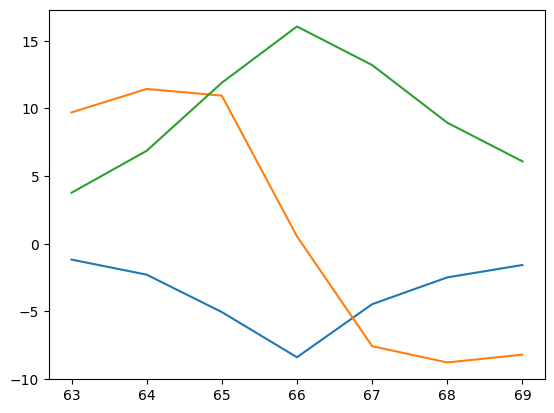

In [12]:
plt.plot(A[:, 306, :])

In [13]:
np.where(A != 0)

(array([ 0,  0,  0, ..., 95, 95, 95]),
 array([   0,    0,    0, ..., 1023, 1023, 1023]),
 array([0, 1, 2, ..., 0, 1, 2]))

In [14]:
wf_arr=model_obj.visualize_shape(306, 30)

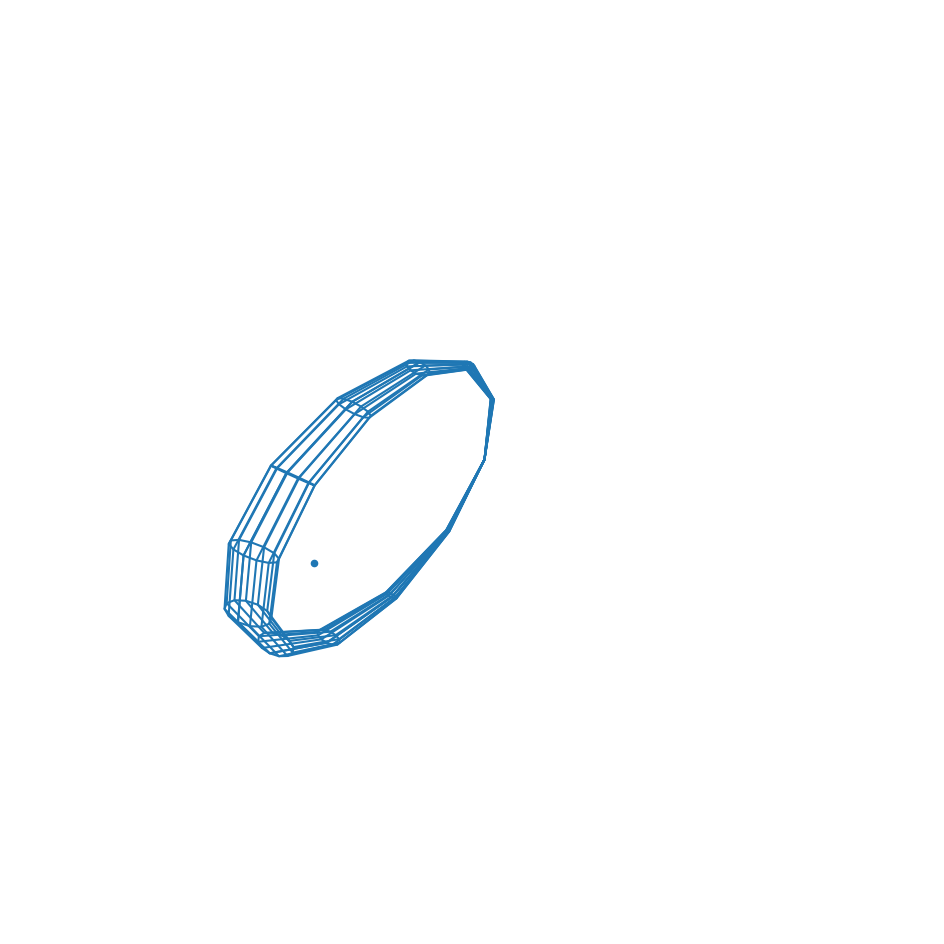

In [15]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(*wf_arr.T)
ax.scatter(1,0,0)
ax.set_axis_off()
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.view_init(elev=25, azim=35)